<a href="https://colab.research.google.com/github/realmeelo/AI_Assignment/blob/main/New_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install libraries
!pip install Opencv-python

In [14]:
#@title Import Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import torch
import torchvision

import numpy as np
import pandas as pd

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob


In [3]:
#@title Unzip file
!unzip /content/armyWorm.zip -d /content/my_dataset

Archive:  /content/armyWorm.zip
replace /content/my_dataset/armyWorm/_94646145_2_jpg.rf.676e742f7bb8fc1cec14c9f0edc9c8c4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#@title Set Random Seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*60)
print("FALL ARMYWORM DETECTION - AI MODEL TRAINING")
print("="*60)


FALL ARMYWORM DETECTION - AI MODEL TRAINING


Found 1928 images in /content/my_dataset/armyWorm/
Successfully loaded and resized 1928 images.


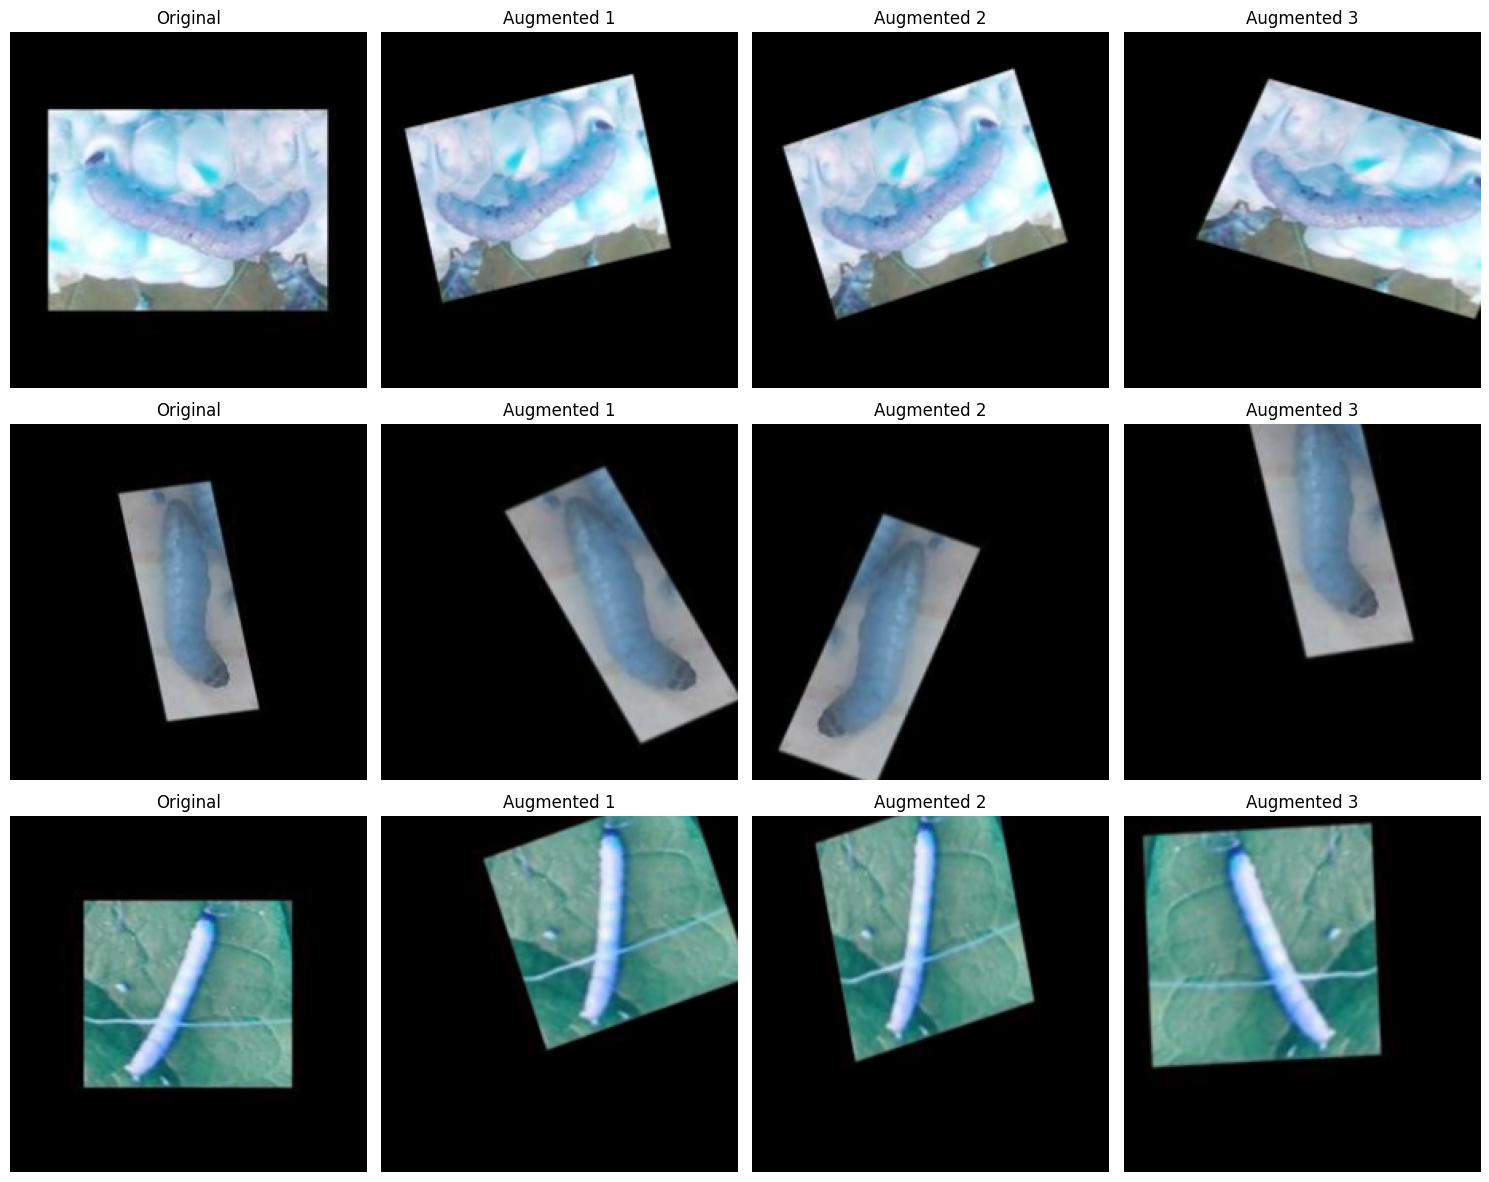

In [4]:
#@title Data Preprocessing

# Load images from the directory using glob
image_dir = '/content/my_dataset/armyWorm/'
image_paths = glob.glob(image_dir + '*.jpg') # Get all .jpg files in the directory

images = []
print(f"Found {len(image_paths)} images in {image_dir}")

for image_path in image_paths:
    try:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        if image is not None:
            # Resize the image
            resized_image = cv2.resize(image, (224, 224)) # Specify desired width and height
            images.append(resized_image)
        else:
            print(f"Warning: Could not load image from {image_path}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")


print(f"Successfully loaded and resized {len(images)} images.")

# Assuming 'images' is a list of loaded and resized images
# Normalize pixel values to be between 0 and 1
normalized_images = [img.astype('float32') / 255.0 for img in images]

# Assuming 'images' is a list of NumPy arrays
# Data Augmentation (setup for a single image, will need adjustment for batch processing)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# To use ImageDataGenerator for augmentation on multiple images, you would typically use flow_from_directory
# or flow method with your image data and labels.
# The following code is for demonstrating augmentation on a single image if needed later.
# Assuming 'image' is a NumPy array and has the shape (height, width, channels)
# Reshape for single image augmentation if needed: (1, height, width, channels)
# image_for_augmentation = np.expand_dims(images[0], axis=0) # Example with the first loaded image

# Generate augmented images (example for a single image)
# augmented_images_iterator = datagen.flow(image_for_augmentation, batch_size=1)

# Display a few augmented images (example for a single image)
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# for i in range(3):
#     augmented_image = augmented_images_iterator.next()[0].astype('uint8')
#     axes[i].imshow(augmented_image)
#     axes[i].axis('off')
# plt.show()

# Demonstrate augmentation on a few loaded images
num_images_to_augment = 3
fig, axes = plt.subplots(num_images_to_augment, 4, figsize=(15, num_images_to_augment * 4))
axes = axes.flatten()

for i in range(num_images_to_augment):
    if i < len(images):
        # Reshape for augmentation (ImageDataGenerator expects a batch)
        image_for_augmentation = np.expand_dims(images[i], axis=0)

        # Original image
        axes[i*4].imshow(images[i])
        axes[i*4].set_title("Original")
        axes[i*4].axis('off')

        # Generate and display augmented images
        augmented_images_iterator = datagen.flow(image_for_augmentation, batch_size=1)
        for j in range(1, 4):
            augmented_image = next(augmented_images_iterator)[0].astype('uint8')
            axes[i*4 + j].imshow(augmented_image)
            axes[i*4 + j].set_title(f"Augmented {j}")
            axes[i*4 + j].axis('off')
    else:
        # Hide unused subplots if fewer than num_images_to_augment are available
        for j in range(4):
            fig.delaxes(axes[i*4 + j])

plt.tight_layout()
plt.show()

In [7]:
#@title Split Data

X_train, X_rem, y_train, y_rem = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem,
    test_size=0.5, # 50% of the remainder (0.5 * 0.3 = 0.15)
    random_state=42,
    stratify=y_rem
)

# Output Summary:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1349
Validation set size: 289
Test set size: 290


In [6]:
# Convert the list of normalized images to a NumPy array
X = np.array(normalized_images)

# Create labels for the images. Assuming all images are 'armyWorm' (class 0)
# You would need to adjust this if you have multiple classes and labels
y = np.zeros(len(X))

print(f"Shape of X (images): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

Shape of X (images): (1928, 224, 224, 3)
Shape of y (labels): (1928,)


In [8]:
# Convert the list of normalized images to a NumPy array
X = np.array(normalized_images)

# Create labels for the images. Assuming all images are 'armyWorm' (class 0)
# You would need to adjust this if you have multiple classes and labels
y = np.zeros(len(X))

print(f"Shape of X (images): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

Shape of X (images): (1928, 224, 224, 3)
Shape of y (labels): (1928,)


In [9]:
#@title Model Architecture
# Define the expected input size (must match your preprocessed image size)
# Using 224x224 RGB images.
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 2

model = Sequential()

# 1. Feature Learning (Convolutional Base)
# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Classification Head (Dense Layers)
# Flatten the 3D feature maps to a 1D vector
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(512, activation='relu'))

# Optional: Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Output layer: uses Softmax for multi-class probability distribution
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Print the model summary to see the layers and parameter count
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,122 (169.36 MB)

 Trainable params: 44,397,122 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#@title Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
    metrics=['accuracy']
)

In [12]:
#@title Model Training

# Train the model
history = model.fit(
    X_train,
    tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES), # One-hot encode training labels
    epochs=8, # You can adjust the number of epochs
    batch_size=65, # You can adjust the batch size
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)) # One-hot encode validation labels
)

Epoch 1/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 173s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 171s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 171s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 168s 8s/step - accuracy: 

In [13]:
#@title Model Evaluation
print("Evaluating model on the Test Set...")

# One-hot encode the test labels
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

loss, accuracy = model.evaluate(
    X_test,
    y_test_one_hot,
    verbose=2 # Displays progress concisely
)

print(f"\nFinal Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

Evaluating model on the Test Set...
10/10 - 10s - 1s/step - accuracy: 1.0000 - loss: 0.0000e+00

Final Test Loss: 0.0000
Final Test Accuracy: 100.00%


In [15]:
#@title Prediction
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true_labels = np.argmax(y_test_one_hot, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [17]:
#@title Confusion Matrix

conf_matrix = confusion_matrix(y_true_labels, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[290]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
